## MNIST Metadata
This notebook will be used to generate the metadata required for the MNIST dataset. This is done to gather dataset statistics and stratify the folds.

In [1]:
import sys
sys.path.append("/home/jupyter-iroy2/advanced-neural-networks")

In [2]:
import numpy as np
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

import advanced_neural_networks
from advanced_neural_networks.dataloader.mnist import MNISTDataset

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_2166508/150644231.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
np.random.seed(42)

In [4]:
def partition_array(arr: np.ndarray, n_partitions):
    partitions = np.array_split(arr, n_partitions)
    return partitions


def stratify_kfolds(metadata_df: pd.DataFrame, kfolds: int):
    label_indices = {}
    labels = sorted((metadata_df["label"].unique().tolist()))
    for label in labels:
        indices = np.array(metadata_df.loc[metadata_df["label"] == label].index)
        label_indices[label] = indices

    metadata_df["fold"] = -1
    
    for label in labels:
        lb_indices = label_indices[label]
        np.random.shuffle(lb_indices)
        label_partitions = partition_array(lb_indices, kfolds)

        for itr, partition in enumerate((label_partitions)):
            metadata_df.loc[partition, "fold"] = itr

    return metadata_df

In [5]:
module_dir = advanced_neural_networks.__path__[0]
dataloader_path = os.path.join(module_dir, "dataloader")
dataset_config = os.path.join(dataloader_path, "mnist_config.yaml")

In [7]:
mnist_train = MNISTDataset(config = dataset_config,
                          location = "cloud",
                          train = True,
                          transforms = [],
                          one_hot=False,
                          data_type="FashionMNIST")

mnist_test = MNISTDataset(config = dataset_config,
                          location = "cloud",
                          train = False,
                          transforms = [],
                          one_hot=False,
                          data_type="FashionMNIST")

In [8]:
train_metadata_df = pd.DataFrame()

for data_point in tqdm(mnist_train):
    x_image, label = data_point
    channels, height, width = list(x_image.shape)
    metadata = {
        "img_channels": channels,
        "height": height,
        "width": width,
        "label": label
    }

    train_metadata_df = pd.concat([train_metadata_df, pd.DataFrame([metadata])], ignore_index=True)
    

100%|██████████| 60000/60000 [00:31<00:00, 1926.86it/s]


In [9]:
train_metadata_df.head()

,img_channels,height,width,label
0,1,28,28,9
1,1,28,28,0
2,1,28,28,0
3,1,28,28,3
4,1,28,28,0


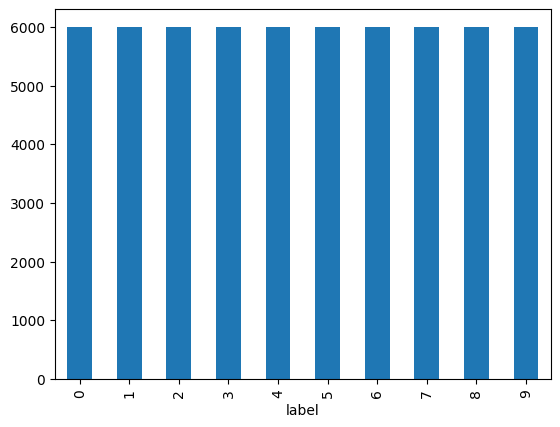

In [10]:
# summary df
train_size_summary = train_metadata_df.groupby("label").size()
train_size_summary.plot(kind = "bar")
plt.show()

In [11]:
## check for corruptions
condition = (train_metadata_df["img_channels"] != 1) | (train_metadata_df["height"] != 28) | (train_metadata_df["width"] != 28)
corrupt_df = train_metadata_df.loc[condition]
corrupt_df

,img_channels,height,width,label


In [12]:
test_metadata_df = pd.DataFrame()

for data_point in tqdm(mnist_test):
    x_image, label = data_point
    channels, height, width = list(x_image.shape)
    metadata = {
        "img_channels": channels,
        "height": height,
        "width": width,
        "label": label
    }

    test_metadata_df = pd.concat([test_metadata_df, pd.DataFrame([metadata])], ignore_index=True)

100%|██████████| 10000/10000 [00:04<00:00, 2037.95it/s]


In [13]:
test_metadata_df.head()

,img_channels,height,width,label
0,1,28,28,9
1,1,28,28,2
2,1,28,28,1
3,1,28,28,1
4,1,28,28,6


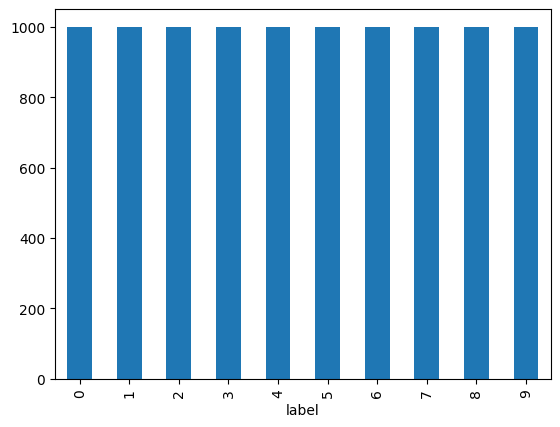

In [14]:
# summary df
test_size_summary = test_metadata_df.groupby("label").size()
test_size_summary.plot(kind = "bar")
plt.show()

In [15]:
## check for corruptions
condition = (test_metadata_df["img_channels"] != 1) | (test_metadata_df["height"] != 28) | (test_metadata_df["width"] != 28)
corrupt_df_test = test_metadata_df.loc[condition]
corrupt_df_test

,img_channels,height,width,label


In [16]:
## save metadata
save_dir = os.path.join(module_dir, "metadata")
train_df_path = os.path.join(save_dir, "fashion_mnist_train_metadata.csv")
train_metadata_df.to_csv(train_df_path, index=False)

test_df_path = os.path.join(save_dir, "fashion_mnist_test_metadata.csv")
test_metadata_df.to_csv(test_df_path, index=False)

In [17]:
## load saved metadata
train_metadata_df = pd.read_csv(train_df_path)
test_metadata_df = pd.read_csv(test_df_path)

In [18]:
train_metadata_df.head()

,img_channels,height,width,label
0,1,28,28,9
1,1,28,28,0
2,1,28,28,0
3,1,28,28,3
4,1,28,28,0


In [19]:
train_metadata_df = stratify_kfolds(train_metadata_df, kfolds = 10)
train_metadata_df.head()

,img_channels,height,width,label,fold
0,1,28,28,9,1
1,1,28,28,0,4
2,1,28,28,0,7
3,1,28,28,3,6
4,1,28,28,0,7


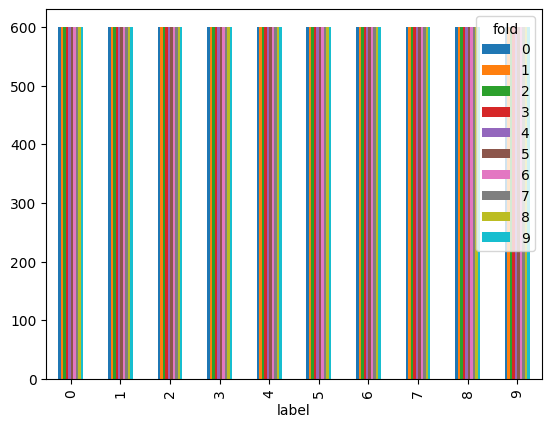

In [21]:
fold_summary = train_metadata_df.groupby(["label", "fold"]).size()
fold_summary.unstack().plot(kind = "bar", stacked = False)
plt.show()

In [22]:
train_metadata_df.head()

,img_channels,height,width,label,fold
0,1,28,28,9,1
1,1,28,28,0,4
2,1,28,28,0,7
3,1,28,28,3,6
4,1,28,28,0,7


In [ ]:
## save train metadata
save_dir = os.path.join(module_dir, "metadata")
train_df_path = os.path.join(save_dir, "fashion_mnist_train_metadata.csv")
train_metadata_df.to_csv(train_df_path, index=False)